In [2]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))


2.6.2
1:  []


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import tabloo
from tensorflow import keras
# from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [208]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
df_normal[['Time']] = scaler.fit_transform(df_normal[['Time']])

# all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
# print((np.sort(all_IDs)))
all_IDs = np.array(['id1','id5'])
print(all_IDs)
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    temp = temp.drop(temp[['ID']],axis =1)
    temp = temp.iloc[0:1000000,0:2]
    df_ID_list.append(temp)

for i in range(len(df_ID_list)):
    # tabloo.show(i)
    print(len(df_ID_list[i]))
    print(df_ID_list[i])

['id1' 'id5']
1034952
                 Time   Signal1  Signal2
5        7.768963e-07  0.000000     0.00
12       1.743012e-06  0.000000     0.25
20       2.709128e-06  0.000000     0.50
27       3.675243e-06  0.000000     0.75
33       4.641359e-06  0.000000     1.00
...               ...       ...      ...
7417396  9.999955e-01  0.876350     0.50
7417403  9.999965e-01  0.876500     0.75
7417410  9.999974e-01  0.876641     1.00
7417417  9.999984e-01  0.876771     0.00
7417425  9.999994e-01  0.876901     0.25

[1034952 rows x 3 columns]
1034952
                 Time   Signal1   Signal2
0        0.000000e+00  0.000000  0.958686
6        9.661157e-07  0.000000  0.958686
13       1.932231e-06  0.000000  0.958686
21       2.898347e-06  0.000000  0.956420
28       3.864463e-06  0.000000  0.956420
...               ...       ...       ...
7417398  9.999956e-01  0.229719  0.391750
7417404  9.999965e-01  0.231935  0.391132
7417412  9.999975e-01  0.234149  0.391132
7417418  9.999985e-01  0.23629

In [7]:
df_ID_list[1]['Signal1']

0          0.000000
6          0.000000
13         0.000000
21         0.000000
28         0.000000
             ...   
5733501    0.349281
5733509    0.350855
5733514    0.352429
5733524    0.354065
5733529    0.355699
Name: Signal1, Length: 800000, dtype: float64

['id1' 'id5']
250000
         Label          Time  Signal1_of_ID
1            0  5.674957e-08       0.165060
7            0  3.389731e-06       0.165400
16           0  6.722713e-06       0.165821
22           0  1.005570e-05       0.166301
29           0  1.338868e-05       0.166662
...        ...           ...            ...
1791696      0  8.333274e-01       0.409938
1791705      0  8.333307e-01       0.409137
1791711      0  8.333341e-01       0.408346
1791718      0  8.333374e-01       0.407586
1791726      0  8.333407e-01       0.406815

[250000 rows x 3 columns]
250000
         Label      Time  Signal1_of_ID
4            0  0.000001       0.037628
12           0  0.000005       0.037723
19           0  0.000008       0.037833
27           0  0.000011       0.037915
32           0  0.000015       0.037969
...        ...       ...            ...
1791700      0  0.833328       0.093077
1791708      0  0.833332       0.092897
1791713      0  0.833335       0.092724
1791723      0  0

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

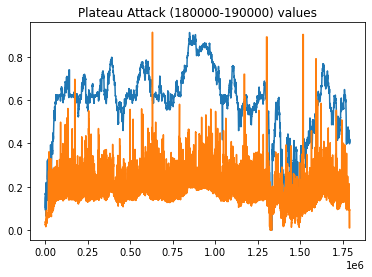

In [104]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1.dropna(axis=1, how='all')
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:400000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

all__test_IDs = np.array(['id1','id5'])
print(all_IDs)
df_testID_list = list()

for i in all__test_IDs:
    tempTest = df_test_plat_ID1[df_test_plat_ID1['ID']==i].dropna(axis=1, how='all')
    # tempTest = tempTest.drop(tempTest[['Label']],axis =1)
    tempTest = tempTest.drop(tempTest[['ID']],axis =1)
    tempTest = tempTest.iloc[0:250000,0:3]
    df_testID_list.append(tempTest)

for i in range(len(df_testID_list)):
    # tabloo.show(i)
    print(len(df_testID_list[i]))
    print(df_testID_list[i])


plt.plot(df_testID_list[0].iloc[:,2:3])
plt.plot(df_testID_list[1].iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [9]:


# create a test dataset of 30 sequences from the provided Data
def createTestDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1_of_ID'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1_of_ID'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [10]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [15]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)
X_test, Y_test = createTestDataset(df_testID_list, df_testID_list, TIME_STEP)

# X_train.shape

# X_test.shape

In [16]:
print(X_train.shape)
print(Y_train.shape)

(2, 799970, 30)
(2, 799970)


In [17]:
print(X_test.shape)
print(Y_test.shape)

(2, 249970, 30)
(2, 249970)


In [18]:
a = np.reshape(X_train,(-1,2,30,1))
b = np.reshape(Y_train,(-1,2,1))

print(a.shape)
print(b.shape)

(799970, 2, 30, 1)
(799970, 2, 1)


In [19]:
p = np.reshape(X_test,(-1,2,30,1))
q = np.reshape(Y_test,(-1,2,1))
print(p.shape)
print(q.shape)

(249970, 2, 30, 1)
(249970, 2, 1)


In [20]:
print(a.shape)
print(a)

(799970, 2, 30, 1)
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 ...


 [[[0.33153826]
   [0.33130229]
   [0.33107543]
   ...
   [0.34540754]
   [0.34582986]
   [0.34683258]]

  [[0.33130229]
   [0.33107543]
   [0.33109866]
   ...
   [0.34582986]
   [0.34683258]
   [0.3479615 ]]]


 [[[0.33107543]
   [0.33109866]
   [0.33118159]
   ...
   [0.34683258]
   [0.3479615 ]
   [0.34928084]]

  [[0.33109866]
   [0

In [212]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
# plot_model(model, to_file='model_plot.png', 
#            show_shapes=True, show_layer_names=True,
#            show_layer_activations=False, expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 2, 30, 128)        66560     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 3840)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2, 512)            1966592   
_________________________________________________________________
dense_4 (Dense)              (None, 2, 64)             32832     
_________________________________________________________________
dense_5 (Dense)              (None, 2, 256)            16640     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2, 30)             7710      
Total params: 2,090,334
Trainable params: 2,090,334
Non-trainable params: 0
____________________________________________

#### Model Fitting

In [ ]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("multi_ID_LSTM_autoenc")

Epoch 1/15
24000/24000 [==============================] - 353s 15ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 2/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0122 - val_loss: 0.0046
Epoch 3/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0124 - val_loss: 0.0054
Epoch 4/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0118 - val_loss: 0.0045
Epoch 5/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0114 - val_loss: 0.0031
Epoch 6/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0100 - val_loss: 0.0048
Epoch 7/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 8/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0090 - val_loss: 0.0049
Epoch 9/15
24000/24000 [==============================] - 359s 15ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 10/15
24000/24000 [============

#### Training loss, finding Threshold

In [22]:
reconstructed_model = keras.models.load_model("multi_ID_LSTM_autoenc")

In [23]:
x_test_predict = reconstructed_model.predict(p, verbose=0)
x_train_predict = reconstructed_model.predict(a, verbose=0)

print(x_train_predict.shape)
print(x_test_predict.shape)

(799970, 2, 30)
(249970, 2, 30)


In [211]:
x_test_predict_X= x_test_predict[:,0]
print(x_test_predict[:,0])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,0])
print("\n------------------------------------------------------------------------------------------------------------------\n")
print(x_test_predict[:,1])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,1])

[[0.1657125  0.16553    0.16408825 ... 0.165113   0.16465744 0.16500902]
 [0.16516465 0.16498229 0.16353932 ... 0.16456589 0.16410881 0.16446108]
 [0.164761   0.16457874 0.16313487 ... 0.16416278 0.1637046  0.16405734]
 ...
 [0.10017538 0.10000932 0.09842408 ... 0.09966481 0.0990274  0.09945947]
 [0.1034652  0.10329837 0.10172027 ... 0.10295022 0.10232192 0.10274994]
 [0.10386097 0.10369402 0.10211676 ... 0.10334539 0.10271817 0.10314572]]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[[[0.16505995]
  [0.16540026]
  [0.1658207 ]
  ...
  [0.168033  ]
  [0.16778276]
  [0.16760261]]

 [[0.1658207 ]
  [0.16630121]
  [0.16666157]
  ...
  [0.16760261]
  [0.16741244]
  [0.1672623 ]]

 [[0.16666157]
  [0.16690179]
  [0.16701191]
  ...
  [0.1672623 ]
  [0.16715218]
  [0.16702208]]

 ...

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09382376]
  [0.09363249]
  [0.09344575]]

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09344575

In [47]:
x_train_predict_res_1 = np.reshape(x_train_predict[:,0],(-1,30,1))
x_train_predict_res_2 = np.reshape(x_train_predict[:,1],(-1,30,1))
x_test_predict_res_1 = np.reshape(x_test_predict[:,0],(-1,30,1))
x_test_predict_res_2 = np.reshape(x_test_predict[:,1],(-1,30,1))

print(x_train_predict_res_1.shape)
print(x_train_predict_res_2.shape)
print(x_test_predict_res_1.shape)
print(x_test_predict_res_2.shape)

(799970, 30, 1)
(799970, 30, 1)
(249970, 30, 1)
(249970, 30, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

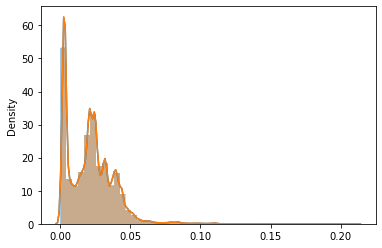

In [210]:
# Seperate test loss calculation
train_mae_loss_1 = np.mean(np.abs(x_train_predict_res_1 - a[:,0]), axis=1)
train_mae_loss_2 = np.mean(np.abs(x_train_predict_res_2 - a[:,1]), axis=1)
sns.distplot(train_mae_loss_1,bins=50,kde=True )
sns.distplot(train_mae_loss_2,bins=50,kde=True )

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

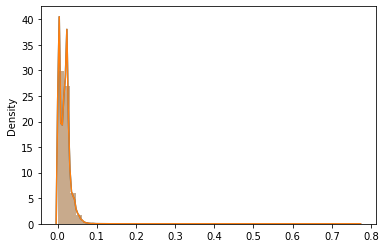

In [209]:
# Seperate test loss calculation
test_mae_loss_1 = np.mean(np.abs(x_test_predict_res_1 - p[:,0]), axis=1)
test_mae_loss_2 = np.mean(np.abs(x_test_predict_res_2 - p[:,1]), axis=1)
sns.distplot(test_mae_loss_1,bins=50,kde=True )
sns.distplot(test_mae_loss_2,bins=50,kde=True )

In [52]:
yo = df_testID_list[0][TIME_STEP:].Signal1_of_ID
yo = yo.dropna()
yo.head()

215    0.167412
221    0.167262
230    0.167152
236    0.167022
243    0.166892
Name: Signal1_of_ID, dtype: float64

In [53]:
print(df_testID_list[1][TIME_STEP:].Signal1_of_ID)

219        0.038051
227        0.038026
234        0.037997
242        0.037967
247        0.037947
             ...   
1791700    0.093077
1791708    0.092897
1791713    0.092724
1791723    0.092549
1791728    0.092410
Name: Signal1_of_ID, Length: 249970, dtype: float64


In [99]:
df_testID_list[0][TIME_STEP:].Signal1_of_ID

AttributeError: 'DataFrame' object has no attribute 'Signal1_of_ID'

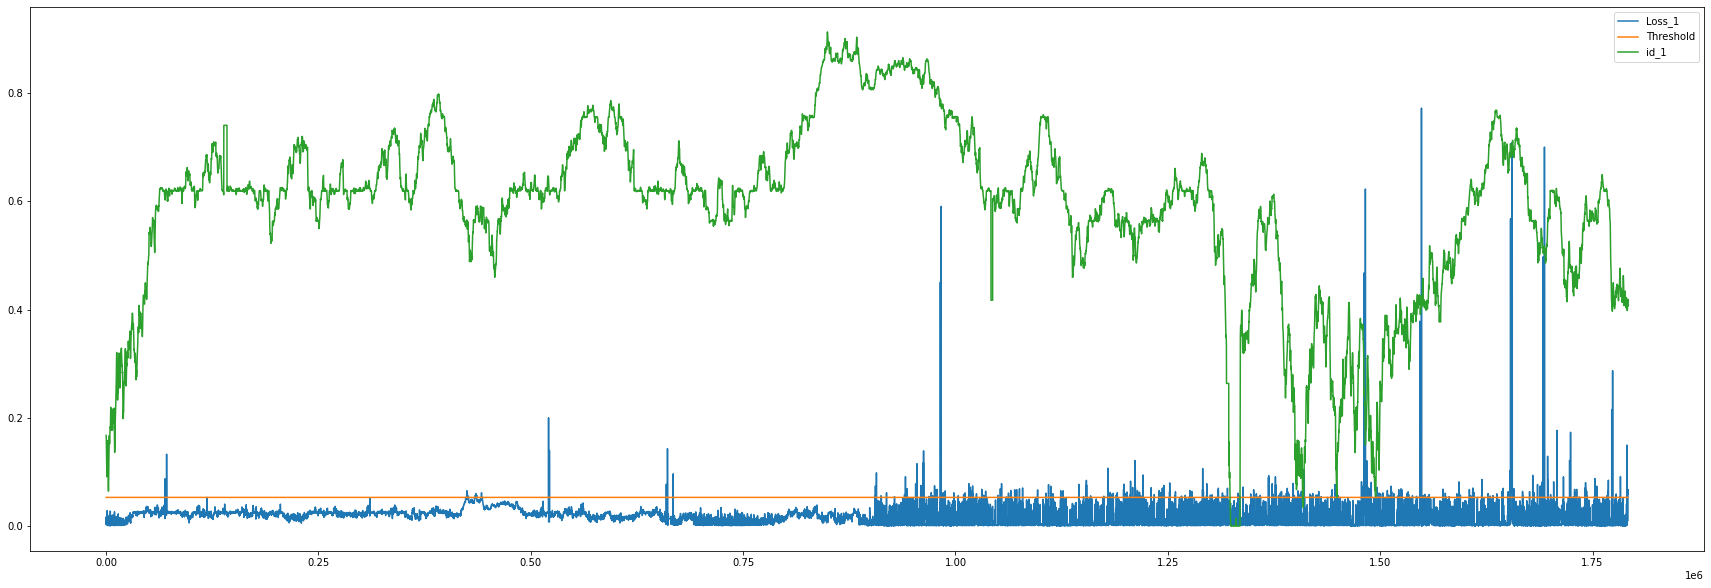

In [105]:
# #plot the threshoold vs the actual loss values
test_score_df = pd.DataFrame(index=df_testID_list[0][TIME_STEP:].index)
test_score_df['id_1'] = df_testID_list[0][TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_testID_list[0][TIME_STEP:].Label
test_score_df['loss_1'] = test_mae_loss_1
test_score_df['threshold'] = 0.053
test_score_df['anomaly_1'] = test_score_df.loss_1 > test_score_df.threshold

plt.figure(figsize=(30,10))
plt.plot(test_score_df.index,test_score_df.loss_1, label='Loss_1')
plt.plot(test_score_df.index,test_score_df.threshold, label='Threshold')
plt.plot(test_score_df.index,test_score_df.id_1, label='id_1')
plt.legend()

In [106]:

print(df_testID_list[0][TIME_STEP:].head())

     Label      Time  Signal1_of_ID
215      0  0.000100       0.167412
221      0  0.000103       0.167262
230      0  0.000107       0.167152
236      0  0.000110       0.167022
243      0  0.000113       0.166892


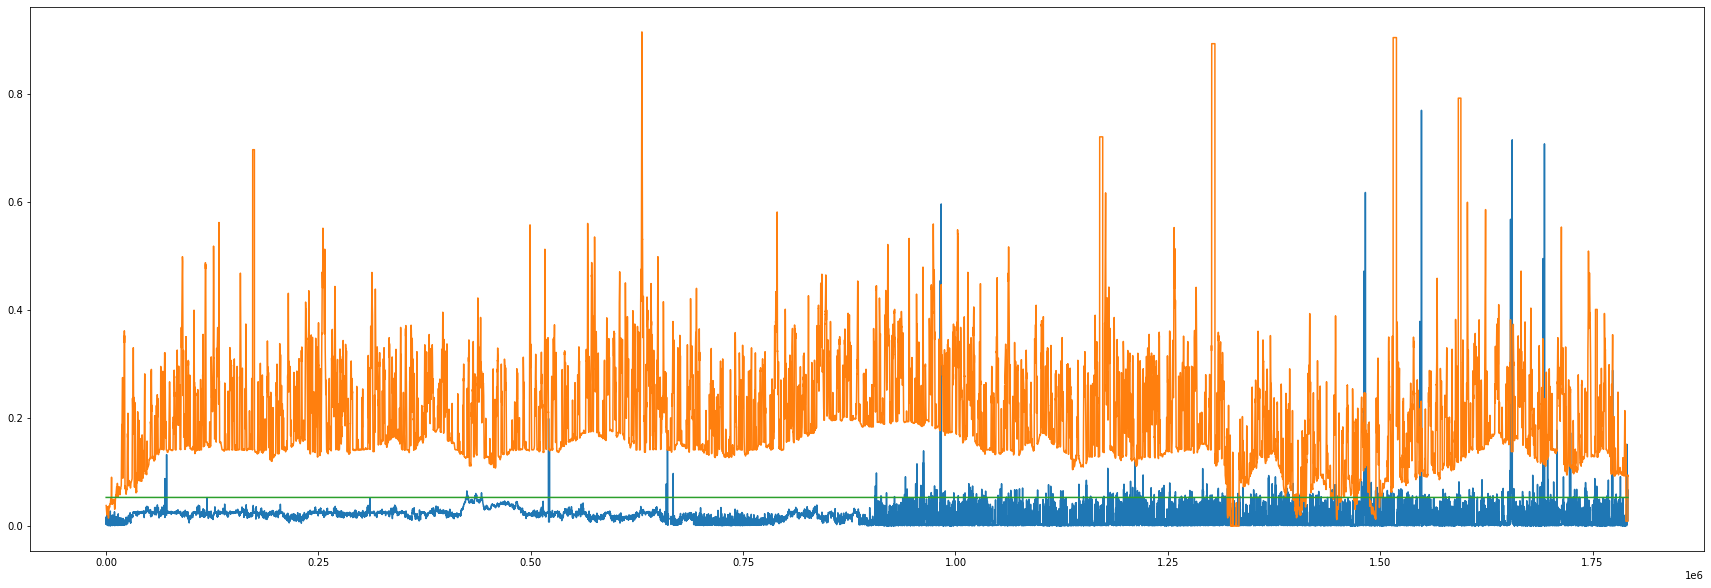

In [107]:
# #plot the threshoold vs the actual loss values
test_score_df_2 = pd.DataFrame(index=df_testID_list[1][TIME_STEP:].index)
test_score_df_2['id_5'] = df_testID_list[1][TIME_STEP:].Signal1_of_ID
test_score_df_2['Label'] = df_testID_list[1][TIME_STEP:].Label
test_score_df_2['loss_2'] = test_mae_loss_2
test_score_df_2['threshold'] = 0.053
test_score_df_2['anomaly_2'] = test_score_df_2.loss_2 > test_score_df_2.threshold

plt.figure(figsize=(30,10))
plt.plot(test_score_df.index,test_score_df_2.loss_2, label=';oss_2')
plt.plot(test_score_df.index,test_score_df_2.id_5, label='id_5')
plt.plot(test_score_df.index,test_score_df_2.threshold, label='Threshold')

In [197]:
anomalies_1 = test_score_df[test_score_df.anomaly_1 == True]
anomalies_2 = test_score_df_2[test_score_df_2.anomaly_2 == True]
stats = np.empty([2,2])
stats[0][0] = (anomalies_1[anomalies_1.Label == anomalies_1.anomaly_1]).iloc[:,0].shape[0]
TPs_1 = anomalies_1[anomalies_1.Label == anomalies_1.anomaly_1]
stats[0][1] = (anomalies_1[anomalies_1.Label != anomalies_1.anomaly_1]).iloc[:,0].shape[0]
FPs_1 = anomalies_1[anomalies_1.Label != anomalies_1.anomaly_1]


stats[1][0] = (anomalies_2[anomalies_2.Label == anomalies_2.anomaly_2]).iloc[:,0].shape[0]
TPs_2 = anomalies_2[anomalies_2.Label == anomalies_2.anomaly_2]

stats[1][1] = (anomalies_2[anomalies_2.Label != anomalies_2.anomaly_2]).iloc[:,0].shape[0]
FPs_2 = anomalies_2[anomalies_2.Label != anomalies_2.anomaly_2]


stats


array([[ 839., 3833.],
       [ 838., 3846.]])

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


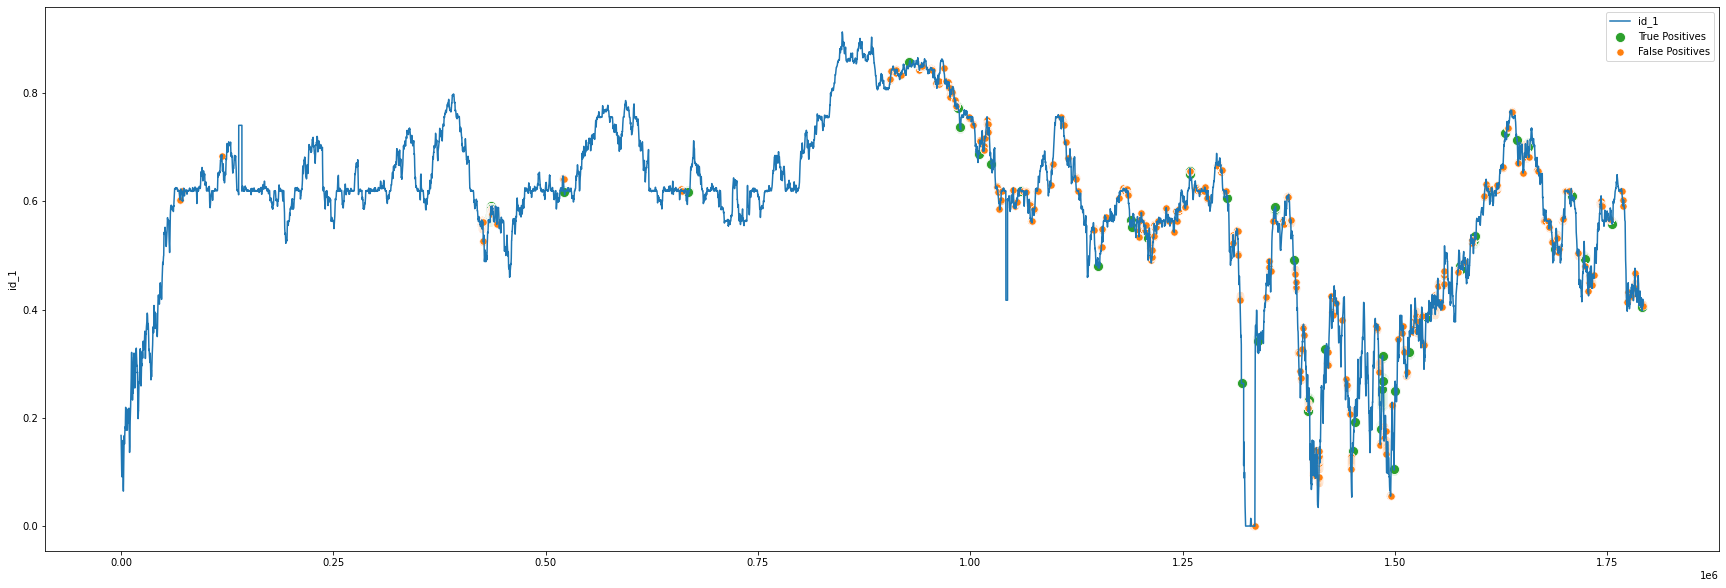

In [198]:
plt.figure(figsize=(30,10))
plt.plot(
  test_score_df.index, 
  test_score_df.id_1, 
  label='id_1'
);

sns.scatterplot(
  TPs_1.index, 
  TPs_1.id_1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives'
)

sns.scatterplot(
  FPs_1.index, 
  FPs_1.id_1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives'
)
plt.legend();

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


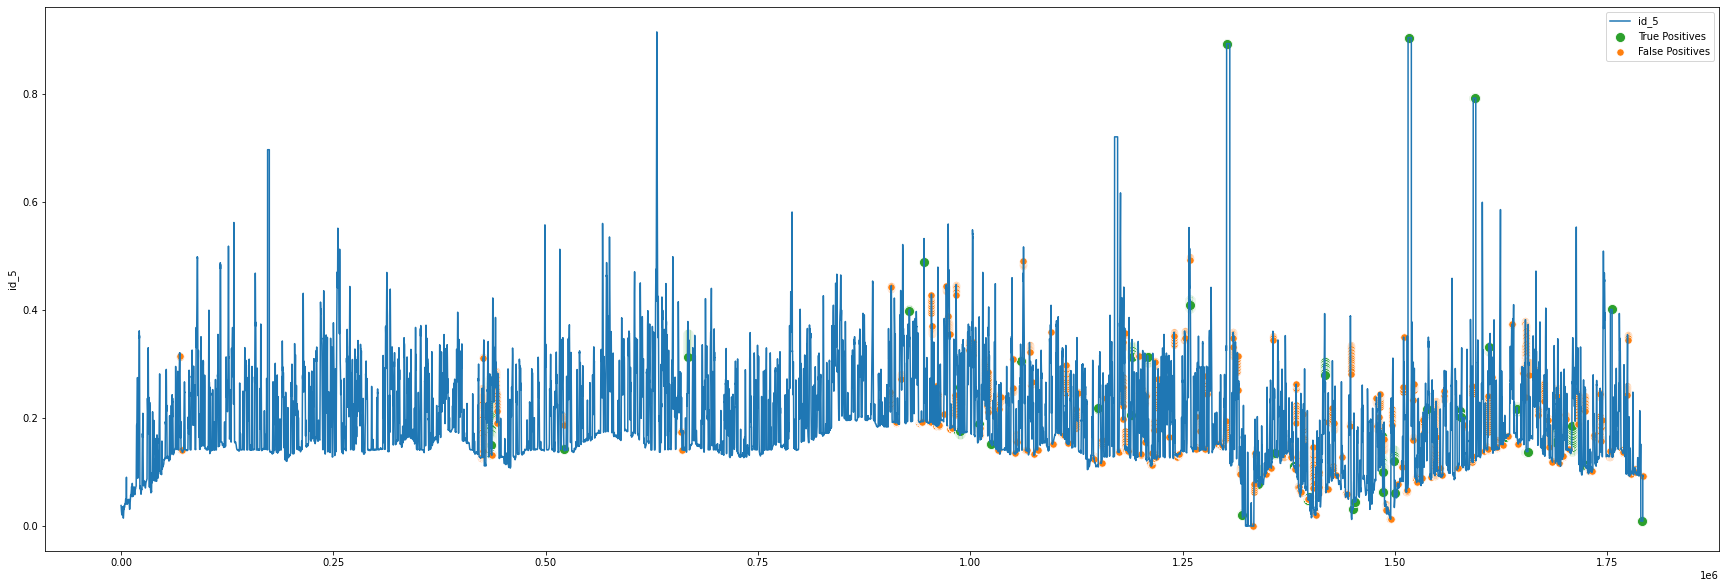

In [199]:
plt.figure(figsize=(30,10))
plt.plot(
  test_score_df_2.index, 
  test_score_df_2.id_5, 
  label='id_5'
);

sns.scatterplot(
  TPs_2.index, 
  TPs_2.id_5,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives'
)

sns.scatterplot(
  FPs_2.index, 
  FPs_2.id_5,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives'
)
plt.legend();

#### Pie charts of TPs vs FPs for All the IDs

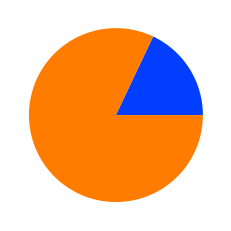

In [205]:

pallete = sns.color_palette('bright')

plt.pie(
 stats[0],
 colors = pallete)
plt.show()

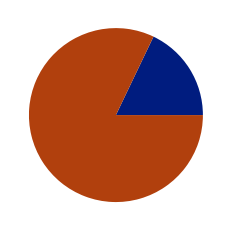

In [207]:

pallete = sns.color_palette('dark')

plt.pie(
 stats[1],
 colors = pallete)
plt.show()